### Import-import library

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Load Data

In [94]:
# Define the path to the CSV file
data_path = os.path.join(os.getcwd(),'preprocessed_data.csv')

# Load the dataset
df = pd.read_csv(data_path)

In [95]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
ycol = df['average_daily_rate'] 
xcol = df.drop(columns=['property_name', 'room_id', 'average_daily_rate'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.1, random_state=42)

### Baseline RandomForestRegressor

In [96]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    n_jobs=-1
)

# print parameters
print("Parameters used by RandomForestRegressor:")
# for param, value in rf_regressor.get_params().items():
#     print(f"{param}: {value}")

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Parameters used by RandomForestRegressor:


Training MAE: 36765.73072506858
Test MAE: 57430.96027075492


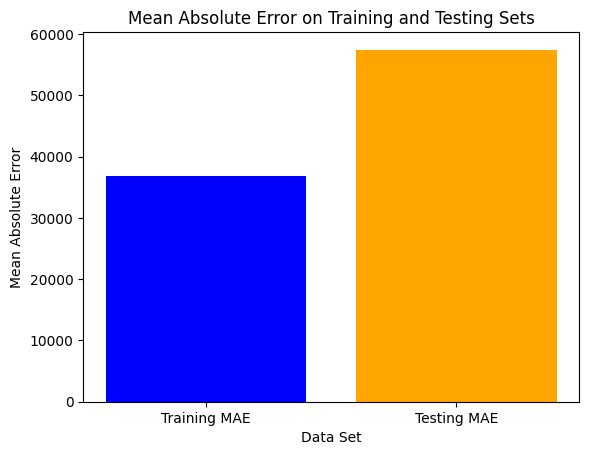

In [97]:
# Evaluasi model menggunakan MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### RandomForestRegressor dengan Grid Search


In [12]:
from sklearn.model_selection import GridSearchCV

# Definisikan model
rf_regressor_tuned = RandomForestRegressor(random_state=42)

# Definisikan grid parameter
param_grid = {
    'n_estimators': [90, 100, 110],
    'max_features': [1, 2, 3],
    'max_depth' : [None, 10,20,30],
    'min_samples_split' : [2,3,4],
    'min_samples_leaf' : [1,2,3],
    'bootstrap': [True, False]
}

# Atur Grid Search
grid_search_rf = GridSearchCV(estimator=rf_regressor_tuned, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit Grid Search
grid_search_rf.fit(x_train, y_train)

# Dapatkan parameter terbaik dan skor terbaik
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f'Parameter Terbaik: {best_params_rf}')
print(f'Error Mutlak Rata-rata Terbaik: {-best_score_rf}')


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Parameter Terbaik: {'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Error Mutlak Rata-rata Terbaik: 129629.58035960814


In [98]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 34218.04108245864
Test MAE: 120123.78480738818


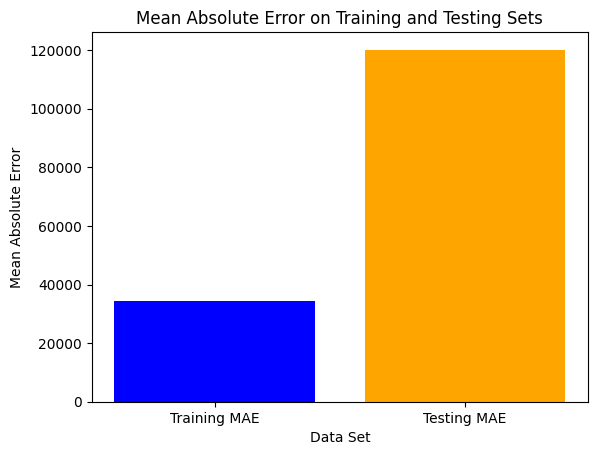

In [99]:
# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Cross Validation


In [100]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# Define your RandomForestRegressor model
rf_regressor_cv = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(rf_regressor_cv, x_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
rf_regressor_cv.fit(x_train, y_train)

# Make predictions on the test data
y_pred_test_cv = rf_regressor_cv.predict(x_test)

# Evaluate the model on the test data
testing_mae_cv = mean_absolute_error(y_test, y_pred_test_cv)
print(f'Mean Absolute Error on Testing: {testing_mae_cv}')


Cross-Validation MAE Scores: [132979.64109357 127827.01669439 128075.99024591 129748.94446764
 130241.81561438]
Mean Cross-Validation MAE: 129774.68162317637
Mean Absolute Error on Testing: 118846.24010008694


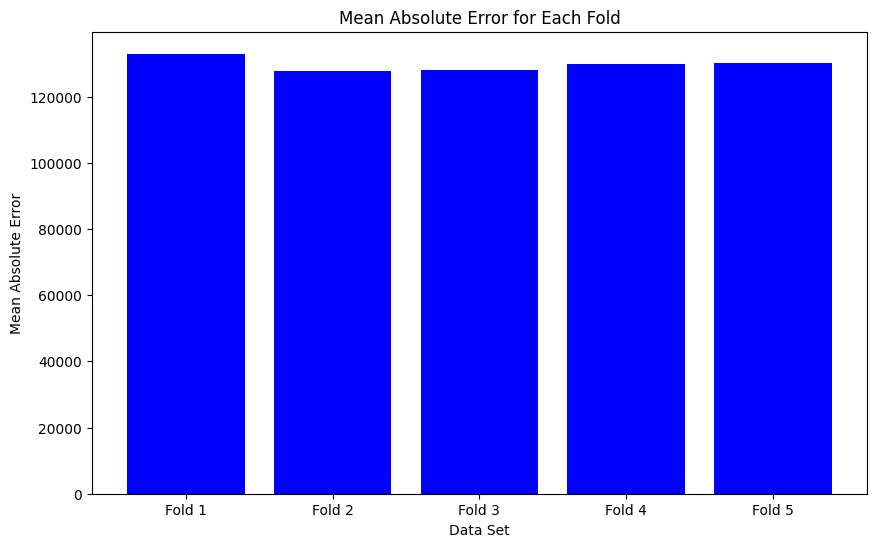

In [101]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

### Tampilkan variabel-variabel penting

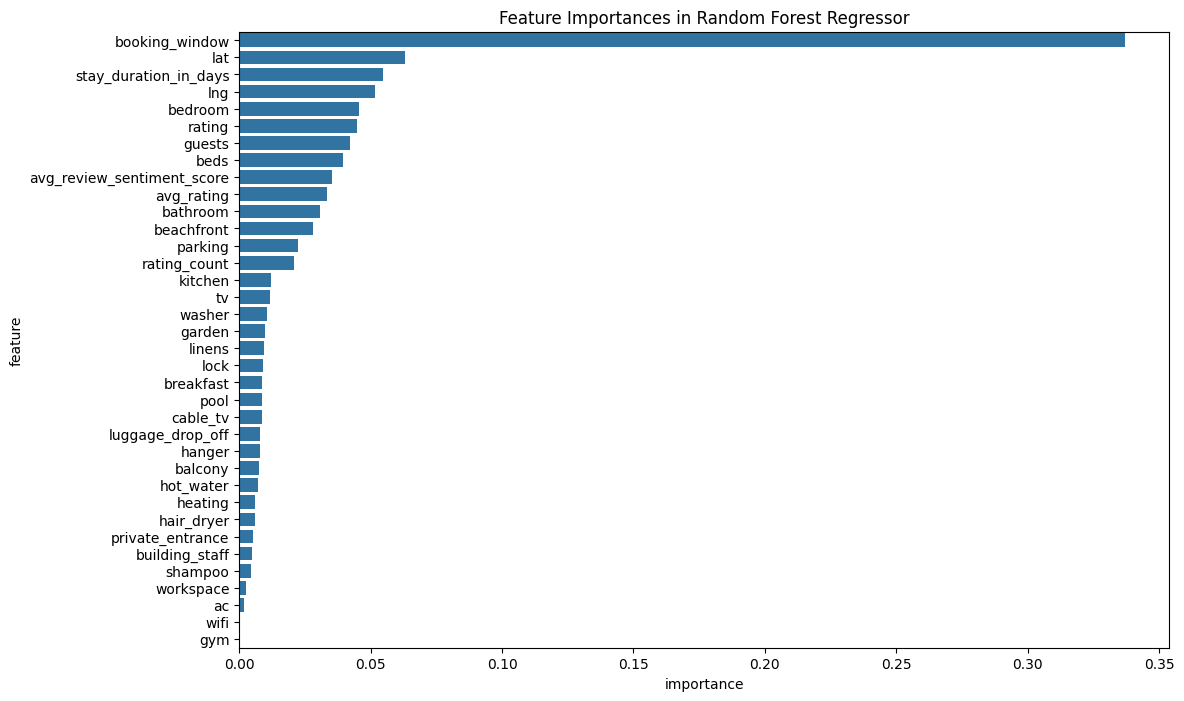

In [102]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': xcol.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()

### RandomForestRegressor dengan Parameter Terbaik dan 7 Fitur Paling Penting


##### definisi ulang xcol

In [103]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
xcol = df[[
    'booking_window',
    'stay_duration_in_days',
    'lat',
    'beds',
    'bedroom',
    'bathroom',
    'parking',
    'pool',
    'beachfront',
    #'avg_rating',
    'lng',
]]

# Split data menjadi set training dan testing
x_train, x_test, y_train, y_test = train_test_split(xcol, ycol, test_size=0.1, random_state=42)

##### buat ulang RandomForestRegressor

In [104]:
# menggunakan RandomForestRegressor dengan parameter terbaik
rf_regressor = RandomForestRegressor(
    max_depth=30,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=110,
    bootstrap=False,
    n_jobs=-1
)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 49395.32270174994
Test MAE: 58390.00142339053


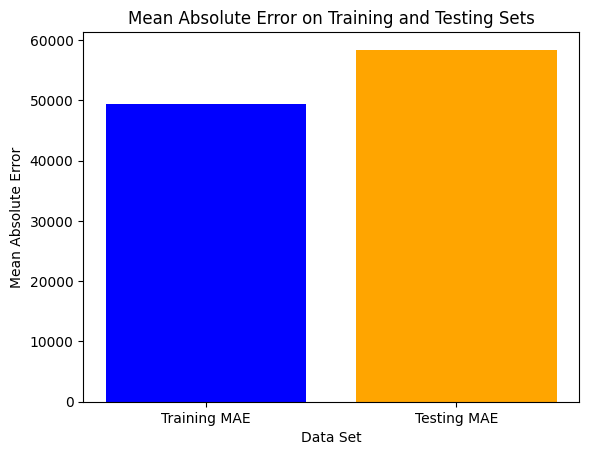

In [105]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Plot  MAE
mae_values = [train_mae, test_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Simpan model dan lakukan percobaan

In [106]:
import joblib

# Save the trained model to a file
joblib.dump(rf_regressor, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [107]:
# Load the trained Random Forest model
randomforest_model = joblib.load('random_forest_model.pkl')

# Use Random Forest model to make predictions
randomforest_predictions_test = randomforest_model.predict(x_test)

# Now you can use these predictions
print("Predictions:", randomforest_predictions_test[:10])
print("Actual Prices:", y_test[:10])

Predictions: [ 693147.          640148.          261240.89621951  424129.37149533
  760148.38        579425.51724138  410590.767677    427914.81038372
 1297758.          520116.        ]
Actual Prices: 10421    6.931470e+05
38682    6.401480e+05
52433    2.375395e+05
20696    4.901375e+05
31618    7.601484e+05
32742    8.901820e+05
46135    3.264308e+05
586      3.150315e+05
30240    1.297758e+06
51241    5.201160e+05
Name: average_daily_rate, dtype: float64


In [108]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
predicted_column = xcol

In [109]:
predicted_column.head()

,booking_window,stay_duration_in_days,lat,beds,bedroom,bathroom,parking,pool,beachfront,lng
0,81,4,-8.805646,1,1,1,0,0,1,115.113378
1,81,4,-8.805646,1,1,1,0,0,1,115.113378
2,81,4,-8.805646,1,1,1,0,0,1,115.113378
3,81,4,-8.805646,1,1,2,0,0,1,115.113378
4,81,4,-8.805646,1,1,2,0,0,1,115.113378


In [110]:
predicted_column.shape

(57019, 10)

In [111]:
distinct_data = xcol.drop_duplicates(subset=['property_name', 'room_id'])

KeyError: Index(['property_name', 'room_id'], dtype='object')

In [ ]:
distinct_data.shape

In [ ]:
distinct_data.to_csv('random_forest_distinct_data.csv', index=False)

In [ ]:
import pandas as pd
from datetime import date
import joblib


def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict(predicted_df, property_name, room_id, check_in, check_out):
    # Select property name and room_id
    filtered_df = predicted_df[(predicted_df['property_name'] == property_name) & 
                              (predicted_df['room_id'] == room_id)].copy()
    
    if filtered_df.empty:
        raise ValueError("No matching property_name and room_id found in the data")
    
    # Save the current price
    current_price = filtered_df['average_daily_rate'].values
    
    # Drop unnecessary columns
    filtered_df.drop(columns=['property_name', 'room_id', 'average_daily_rate'], inplace=True)
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    # Replace values in columns
    filtered_df['stay_duration_in_days'] = stay_duration_days
    filtered_df['booking_window'] = booking_window_days
    
    print("Booking window (days):", booking_window_days)
    print("Stay duration (days):", stay_duration_days)
    
    # Predict
    random_forest_model = joblib.load('random_forest_model.pkl')
    xgboost_predictions_test = random_forest_model.predict(filtered_df)
    
    return xgboost_predictions_test, current_price

def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"

# Example usage
check_in = date(2024, 12, 1)
check_out = date(2024, 12, 30)

prediction, current_price = predict(distinct_data, 'Amazon Guesthouse', 397693, check_in, check_out)
formatted_current_price = format_currency(current_price[0])
formatted_prediction = format_currency(prediction[0])

print("Current Price:", formatted_current_price)
print("Prediction:", formatted_prediction)

In [ ]:
from datetime import date
import joblib

def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict_new_data(distance_to_coastline, lat, lng, check_in, check_out):
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    data = np.array([[booking_window_days, 
                      distance_to_coastline,
                      stay_duration_days, 
                      lat, 
                      lng]])
    
    random_forest_model = joblib.load('random_forest_model.pkl')
    random_forest_prediction = random_forest_model.predict(data)
    
    return random_forest_prediction


def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"


check_in = date(2024, 12, 1)
check_out = date(2024, 12, 30)

prediction = predict_new_data(1, 1, 1, check_in, check_out)
print("Prediction:", format_currency(prediction[0]))
